# Deep Learning Práctico 2
## Implementación de una red neuronal RNN

In [1]:
#CORRER UNA VEZ
# !mkdir ./data
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
# !tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
# !pip install mlflow
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -o ./SBW-vectors-300-min5.txt.bz2

### Librerías

In [2]:
import csv
import gzip
import bz2
import mlflow
import numpy as np
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange

import json
import matplotlib.pyplot as plt
import seaborn as sns
import functools
tqdm.pandas()


## Dataset

Utilizamos el dataset del Meli Challenge 2019. El mismo contiene los datos de publicaciones de ventas en Mercado Libre.

En este caso tomamos los datos en español solamente quedando 6.119.100 registros en total y 632 categorías únicas.

Se descartaron las columnas ya trabajadas y se realizó el tokenizado preprocesado desde 0 utilizando solamente la columna `title` como `data` y `category` como `target`.


In [3]:
class MeliChallenge(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Lectura de datos y Analisis exploratorio

In [4]:
columns_interesting = ['title','category']

### Train

In [5]:
train = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)


In [6]:
train_dataset = train[columns_interesting]
train_dataset.head()

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES


Como el dataset ya viene separado en **train - validation - test**, armo uno completo `fulldataset` para extraer el diccionario con todas las palabras.

In [7]:
fulldataset=train_dataset.copy()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895280 entries, 0 to 4895279
Data columns (total 10 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   language         object
 1   label_quality    object
 2   title            object
 3   category         object
 4   split            object
 5   tokenized_title  object
 6   data             object
 7   target           int64 
 8   n_labels         int64 
 9   size             int64 
dtypes: int64(3), object(7)
memory usage: 373.5+ MB


In [9]:
#Conteo de registros nulos por columna
train.isnull().sum()

language           0
label_quality      0
title              0
category           0
split              0
tokenized_title    0
data               0
target             0
n_labels           0
size               0
dtype: int64

### Test

In [10]:
test = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)


In [11]:
test_dataset = test[columns_interesting]
test_dataset.head()

,title,category
0,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS
1,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS
2,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS
3,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS
4,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63680 entries, 0 to 63679
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   language         63680 non-null  object
 1   label_quality    63680 non-null  object
 2   title            63680 non-null  object
 3   category         63680 non-null  object
 4   split            63680 non-null  object
 5   tokenized_title  63680 non-null  object
 6   data             63680 non-null  object
 7   target           63680 non-null  int64 
 8   n_labels         63680 non-null  int64 
 9   size             63680 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 4.9+ MB


In [13]:
#Conteo de registros nulos por columna
test.isnull().sum()

language           0
label_quality      0
title              0
category           0
split              0
tokenized_title    0
data               0
target             0
n_labels           0
size               0
dtype: int64

In [14]:
fulldataset=fulldataset.append(test_dataset, ignore_index = True)

/tmp/ipykernel_2109455/2648159511.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fulldataset=fulldataset.append(test_dataset, ignore_index = True)


## Validation

In [15]:
validation = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)


In [16]:
validation_dataset = validation[columns_interesting]
validation_dataset.head()

,title,category
0,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS
1,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS
2,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS
3,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES
4,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS


In [17]:
validation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223820 entries, 0 to 1223819
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   title     1223820 non-null  object
 1   category  1223820 non-null  object
dtypes: object(2)
memory usage: 18.7+ MB


In [18]:
#Conteo de registros nulos por columna
validation.isnull().sum()

language           0
label_quality      0
title              0
category           0
split              0
tokenized_title    0
data               0
target             0
n_labels           0
size               0
dtype: int64

In [19]:
fulldataset=fulldataset.append(validation_dataset, ignore_index = True)
fulldataset.shape

/tmp/ipykernel_2109455/1469928329.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fulldataset=fulldataset.append(validation_dataset, ignore_index = True)


(6182780, 2)

In [20]:
fulldataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6182780 entries, 0 to 6182779
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   title     object
 1   category  object
dtypes: object(2)
memory usage: 94.3+ MB


/tmp/ipykernel_2109455/3843078232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['len'] = df_filter['title'].apply(lambda x : len(x))


<AxesSubplot:ylabel='Frequency'>

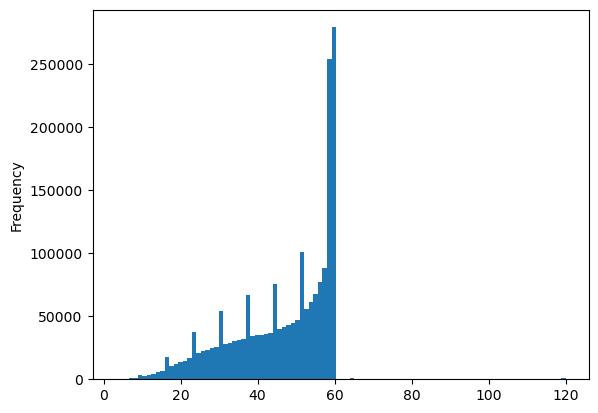

In [21]:
# Realizamos conteo de caracteres para el campo title
df_filter = fulldataset[:2000000]
df_filter['len'] = df_filter['title'].apply(lambda x : len(x))
df_filter['len'].plot.hist(bins=100)

In [22]:
#Conteo de titulos por cada categoría
count_df = df_filter[['category','title']].groupby('category').aggregate({'title':'count'}).reset_index().sort_values('title',ascending=False)
count_df

,category,title
90,BOOKS,6213
3,ACTION_FIGURES,6073
365,MAGAZINES,5996
631,WRISTWATCHES,5910
172,DIECAST_VEHICLES,5888
...,...,...
142,COIL_BINDING_MACHINES,294
561,TANDEM_CHAIRS,282
318,INDUSTRIAL_ICE_CREAM_MACHINES,233
502,SCREEN_PRINTING_FRAMES,155


In [23]:
print("cantidad de categorías de subconjunto train {}".format(len(train_dataset.category.unique())))

cantidad de categorías de subconjunto train 632


In [24]:
print("cantidad de títulos de subconjunto train  {}".format(len(train_dataset.title.unique())))

cantidad de títulos de subconjunto train  4895280


In [25]:
print("cantidad de categorías de subconjunto test {}".format(len(test_dataset.category.unique())))

cantidad de categorías de subconjunto test 632


In [26]:
print("cantidad de títulos de subconjunto test{}".format(len(test_dataset.title.unique())))

cantidad de títulos de subconjunto test63680


In [27]:
print("cantidad de categorías de subconjunto validation {}".format(len(validation_dataset.category.unique())))

cantidad de categorías de subconjunto validation 632


In [28]:
print("cantidad de títulos de subconjunto validation {}".format(len(validation_dataset.title.unique())))

cantidad de títulos de subconjunto validation 1223820


## Preprocess


En este caso vamos a utilizar un sólo módulo para transformar los datos. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings.

Vamos a estar trabajando con la librería gensim previamente importada para el procesamiento del lenguaje natural (pueden ver su código open source en este link ).

In [29]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [30]:
preprocess_full = RawDataProcessor(fulldataset)
test_dataset = MeliChallenge(test_dataset, transform=preprocess_full)
train_dataset = MeliChallenge(train_dataset, transform=preprocess_full)
validation_dataset = MeliChallenge(validation_dataset, transform=preprocess_full)

In [31]:
print(f"Datasets loaded with {len(fulldataset)} elements")

print(f"train elements  {len(train_dataset)}")
print(f"validation elements {len(validation_dataset)}")
print(f"test elements {len(test_dataset)}")

print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 6182780 elements
train elements  4895280
validation elements 1223820
test elements 63680
Sample train element:
{'data': [50001, 2, 50000, 3], 'target': 188}


## Collation function

Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un *batch* de datos, el `DataLoader` de PyTorch espera que los datos del *batch* tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de `collate_fn`. En particular, esta función se encarga de tomar varios elementos de un `Dataset` y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch. Se define un módulo `PadSequences` que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (*pad*) y dada una lista de secuencias, devuelve un tensor con *padding* sobre dichas secuencias.

In [32]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra `collation_fn`, podemos definir nuestros `DataLoader`, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en `shuffle`, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante *mini-batchs* nos puede generar inconsistencias.

In [33]:
pad_sequences = PadSequences()
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)


# Entrenamiento de la RED - Experimento 1

### Categoría de la red neuronal recurrente

Para el caso propuesto la red debe tener una arquitectura many-to-one con entrada dada por la secuencia máxima de palabras en nuestro dataset y salida dada por el número de categorías que esperamos clasificar.

## El modelo de clasificación

Para clasificación utilizaremos un perceptrón multicapa de dos capas ocultas. En particular, tenemos la capa de `Embeddings` que es rellenada con los valores de embeddings preentrenados.

### Modelo Baseline

Se diseñó un modelo simple de red RNN de tipo LSTM con una capa de embeddings y la capa de salida.

In [34]:
class ImdbLSTM(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 hidden_layer,
                 num_layers,
                 dropout,
                 bidirectional,
                 freeze_embedings):
        super().__init__()           
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)  
        
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
       
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parameters
        self.lstm = nn.LSTM(vector_size, hidden_layer, batch_first=True)
        
        #fully connected layer parameters
        self.linear1 = nn.Linear(hidden_layer, 632)
    
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        out = self.linear1(ht[-1])
        return out

In [35]:
# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

In [36]:
torch.cuda.is_available()

True

In [37]:
BATCHES_t = (int(len(train_dataset)/batch_size) + int(len(train_dataset) % batch_size>0))
BATCHES_v = (int(len(validation_dataset)/batch_size) + int(len(validation_dataset) % batch_size>0))

In [38]:
#Definimos el modelo
model = ImdbLSTM(
"./SBW-vectors-300-min5.txt.bz2", 
dictionary=preprocess_full.dictionary,
vector_size=300,
hidden_layer=32,
num_layers=1,
dropout=0.1,
bidirectional=True,
freeze_embedings=True,
)

In [39]:
print(model)

ImdbLSTM(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 32, batch_first=True)
  (linear1): Linear(in_features=32, out_features=632, bias=True)
)


## Experimento de MLflow

Por último, ya tenemos todos los bloques para construir nuestro experimento de MLflow. Anotamos los parámetros del modelo y lanzamos a correr nuestro experimento. Cada vez que finaliza un epoch guardamos algunas métricas. Al finalizar todos los epochs corremos algunas métricas extras de evaluación.

In [40]:
#Mandamos modelo a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Hiperparametros
learning_rate = 0.001
EPOCHS = 5
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)


mlflow.set_experiment("Meli_RNN_Baseline_2")

with mlflow.start_run():
    mlflow.log_param("model_name", "RNN_Baseline")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_layer": 32,
        "num_layers": 1,
        "Epochs": EPOCHS,
        "Dropout": 0.1,
        "optimizer": "optim.Adam",
        "Learning Rate": learning_rate
    })


    
    for epoch in trange(EPOCHS):
        model.to(device)
        model.train()
        running_loss = 0.0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(train_loader, total=BATCHES_t)
            
        #Train
        print("Epoch", epoch)
        for idx, batch in enumerate(pbar):
            data = batch["data"].to(device)
            target = batch["target"].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss_function(output, target)
            loss_value.backward()
            optimizer.step()
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
            running_loss += loss_value.item()
            running_loss_flow.append(loss_value.item())
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
        metric = balanced_accuracy_score(targets, predictions)
        mlflow.log_metric("train_balanced_acc", metric, epoch + 1)
        
        model.eval()
        running_loss = 0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(validation_loader, total=BATCHES_v)
        
        # Validation
        with torch.no_grad():
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                pred = torch.max(output, 1)[1]
                loss_value = loss_function(output, target)
                targets.extend(target.cpu().numpy())
                predictions.extend(pred.cpu().numpy())
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
            metric = balanced_accuracy_score(targets, predictions)
            mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

        print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.6716854736627511


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7239287817581089


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7404938796287348


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7498247129912744


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7552591038201194


# Entrenamiento de la RED - Experimento 2


Tambien se hicieron pruebas modificando la arquitectura de la red y para ello se agregó una capa lineal oculta adicional.



### Arquitectura de la Red Neuronal - Experimento 2

In [40]:
class RNNMeLiChallenge(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 hidden_layer,
                 p_dropout,
                 bidirectional,
                 activation_fn):
        super().__init__()
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
                    
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parametros
        self.lstm = nn.LSTM(vector_size, hidden_layer, batch_first=True, bidirectional=bidirectional)
        
        #Parametros de las capas
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear1_dp = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(hidden_layer, 632)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.activation_fn(self.linear1(ht[-1]))
        if self.training:
            x = self.linear1_dp(x)
        out = self.output_layer(x)
        return out

In [41]:
model = RNNMeLiChallenge(pretrained_embeddings_path='./SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess_full.dictionary,
                        vector_size=300,
                        freeze_embedings=True,
                        hidden_layer=254,
                        bidirectional=True,
                        p_dropout=0.1,
                        activation_fn=F.relu)
print(model)

RNNMeLiChallenge(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 254, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=254, out_features=254, bias=True)
  (linear1_dp): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=254, out_features=632, bias=True)
)


## Experimento de MLflow

Por último, ya tenemos todos los bloques para construir nuestro experimento de MLflow. Anotamos los parámetros del modelo y lanzamos a correr nuestro experimento. Cada vez que finaliza un epoch guardamos algunas métricas. Al finalizar todos los epochs corremos algunas métricas extras de evaluación.

In [42]:
#Mandamos modelo a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Hiperparametros

hidden_layer = 254
bidirectional = True
p_dropouts = 0.1
activation_fns = F.relu
lr = 0.001
wd = 0.00001
EPOCHS = 5
loss_function = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)


mlflow.set_experiment("Meli_RNN_Final")

with mlflow.start_run():
    mlflow.log_param("model_name", "RNN_Final")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_layer":256,
        "num_layers": 2,
        "Epochs": EPOCHS,
        "Dropout": p_dropouts,
        "optimizer": optimizer,
        "Learning Rate": lr,
        "weight_decay":wd,
        "Bidireccional":True,
        "activation_fns": activation_fns
    })


    
    for epoch in trange(EPOCHS):
        model.to(device)
        model.train()
        running_loss = 0.0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(train_loader, total=BATCHES_t)
            
        #Train
        print("Epoch", epoch)
        for idx, batch in enumerate(pbar):
            data = batch["data"].to(device)
            target = batch["target"].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss_function(output, target)
            loss_value.backward()
            optimizer.step()
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
            running_loss += loss_value.item()
            running_loss_flow.append(loss_value.item())
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
        metric = balanced_accuracy_score(targets, predictions)
        mlflow.log_metric("train_balanced_acc", metric, epoch + 1)
        
        model.eval()
        running_loss = 0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(validation_loader, total=BATCHES_v)
        
        # Validation
        with torch.no_grad():
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                pred = torch.max(output, 1)[1]
                loss_value = loss_function(output, target)
                targets.extend(target.cpu().numpy())
                predictions.extend(pred.cpu().numpy())
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
            metric = balanced_accuracy_score(targets, predictions)
            mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

        print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')

2022/11/25 21:03:30 INFO mlflow.tracking.fluent: Experiment with name 'Meli_RNN_Final' does not exist. Creating a new experiment.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.8409926455206509


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.8487518754763812


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.8544366637664423


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.8567123085072111


  0%|          | 0/38245 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/9562 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.8589289495134644


In [43]:
runs = mlflow.search_runs()
runs[runs.status == "FINISHED"]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_balanced_acc,metrics.val_balanced_acc,metrics.val_loss,metrics.train_loss,...,params.optimizer,params.model_name,params.embedding_size,params.Bidireccional,params.weight_decay,params.num_layers,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,6193aa1251c74a7686dfc9e75d203337,17,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-26 00:03:32.082000+00:00,2022-11-26 02:18:01.642000+00:00,0.854276,0.858929,0.585177,0.596956,...,Adam (\nParameter Group 0\n amsgrad: False\...,RNN_Final,300,True,1e-05,2,cdagatti,fortunate-colt-280,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL


In [44]:
mlflow.tracking.MlflowClient().list_experiments()
mlflow.search_runs()

/tmp/ipykernel_2109455/802100939.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  mlflow.tracking.MlflowClient().list_experiments()


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_balanced_acc,metrics.val_balanced_acc,metrics.val_loss,metrics.train_loss,...,params.optimizer,params.model_name,params.embedding_size,params.Bidireccional,params.weight_decay,params.num_layers,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,6193aa1251c74a7686dfc9e75d203337,17,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-26 00:03:32.082000+00:00,2022-11-26 02:18:01.642000+00:00,0.854276,0.858929,0.585177,0.596956,...,Adam (\nParameter Group 0\n amsgrad: False\...,RNN_Final,300,True,1e-05,2,cdagatti,fortunate-colt-280,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL


## Predicciones

## Classification report sobre los datos de test.

In [47]:
from sklearn.metrics import classification_report

In [48]:
y_true = []
y_pred = []
with torch.no_grad():
    for data in tqdm(test_loader):
        inputs, labels = data
        outputs = model(data['data'].cuda())
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(data['target'].numpy())
        y_pred.extend(predicted.cpu().numpy())
print('------------TEST------------')
print('Balanced Accuracy score Test: ', balanced_accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(cm)

  0%|          | 0/498 [00:00<?, ?it/s]

------------TEST------------
Balanced Accuracy score Test:  0.9221059209234509
              precision    recall  f1-score   support

           0       0.99      0.77      0.86        98
           1       1.00      0.96      0.98       100
           2       0.90      0.96      0.93        98
           3       0.63      0.80      0.70       102
           4       0.93      0.98      0.96        99
           5       0.85      0.76      0.80        98
           6       0.99      0.92      0.95       100
           7       0.91      0.97      0.94       100
           8       0.97      0.99      0.98       101
           9       0.95      0.99      0.97       104
          10       0.92      0.95      0.93        98
          11       0.89      0.92      0.91       101
          12       0.80      0.84      0.82       102
          13       1.00      0.96      0.98       107
          14       0.90      0.95      0.93        99
          15       0.89      0.83      0.86       100
  

NameError: name 'cm' is not defined

Guardamos el modelo entranado y los pesos calculados

In [49]:
mlflow.tracking.MlflowClient().list_experiments()
mlflow.search_runs()

/tmp/ipykernel_2109455/802100939.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  mlflow.tracking.MlflowClient().list_experiments()


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_balanced_acc,metrics.val_balanced_acc,metrics.val_loss,metrics.train_loss,...,params.optimizer,params.model_name,params.embedding_size,params.Bidireccional,params.weight_decay,params.num_layers,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,6193aa1251c74a7686dfc9e75d203337,17,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-26 00:03:32.082000+00:00,2022-11-26 02:18:01.642000+00:00,0.854276,0.858929,0.585177,0.596956,...,Adam (\nParameter Group 0\n amsgrad: False\...,RNN_Final,300,True,1e-05,2,cdagatti,fortunate-colt-280,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL
